# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [1]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Load all datasets
customers = pl.read_csv('data/Customers.csv')
orders = pl.read_csv('data/Orders.csv')
items = pl.read_csv('data/Items.csv')
products = pl.read_csv('data/Products.csv')
stores = pl.read_csv('data/Stores.csv')
supplies = pl.read_csv('data/Supplies.csv')

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Stores: {stores.shape}")
print(f"Supplies: {supplies.shape}")

Dataset shapes:
Customers: (932, 2)
Orders: (63148, 7)
Items: (90184, 3)
Products: (10, 5)
Stores: (6, 4)
Supplies: (65, 5)


## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [4]:
# Q1.1: Calculate total revenue
# Your code here
total_revenue = orders.select(
    (pl.col("order_total") / 100).sum().alias("total_revenue")
)

total_value = total_revenue.item()

print(f"The total revenue for the Jaffle Shop amounts to ${total_value:,.0f}.")

The total revenue for the Jaffle Shop amounts to $660,382.


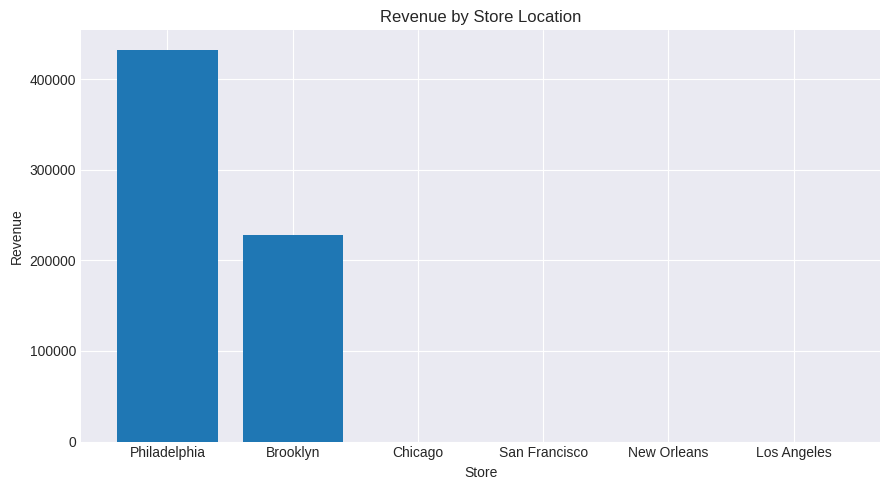

Philadelphia: $432,156
Brooklyn: $228,226
Chicago: $0
San Francisco: $0
New Orleans: $0
Los Angeles: $0


In [5]:
# Q1.2: Revenue by store location
# Your code here
revenue_by_store = (
    stores
    .select([pl.col("id").alias("store_id"), pl.col("name").alias("store_name")])
    .join(
        orders
        .group_by("store_id")
        .agg((pl.col("order_total") / 100).sum().alias("total_revenue")),
        on="store_id",
        how="left",
    )
    .with_columns(pl.col("total_revenue").fill_null(0))
    .sort("total_revenue", descending=True)
)

plt.figure(figsize=(9,5))
plt.bar(
    revenue_by_store["store_name"].to_list(),
    revenue_by_store["total_revenue"].to_list()
)
plt.title("Revenue by Store Location")
plt.xlabel("Store")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

for name, rev in zip(revenue_by_store["store_name"], revenue_by_store["total_revenue"]):
    print(f"{name}: ${rev:,.0f}")

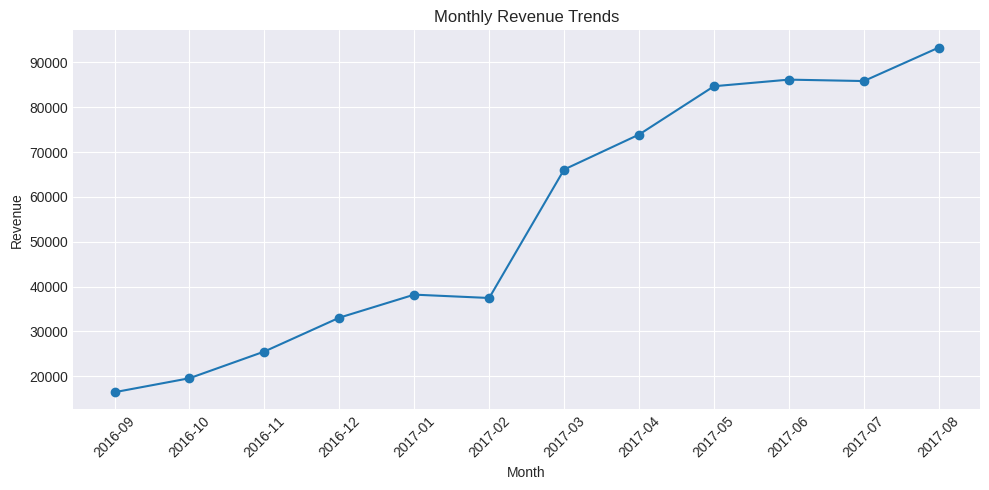

month,total_revenue
datetime[μs],f64
2016-09-01 00:00:00,16449.22
2016-10-01 00:00:00,19566.51
2016-11-01 00:00:00,25526.62
2016-12-01 00:00:00,33073.37
2017-01-01 00:00:00,38212.91
…,…
2017-04-01 00:00:00,73920.14
2017-05-01 00:00:00,84699.09
2017-06-01 00:00:00,86171.48


In [6]:
# Q1.3: Monthly revenue trends
# Your code here
monthly_revenue_trends = (
    orders
    .with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).alias("ordered_at_dt"))
    .with_columns(pl.col("ordered_at_dt").dt.truncate("1mo").alias("month"))
    .group_by("month")
    .agg((pl.col("order_total") / 100).sum().alias("total_revenue"))
    .sort("month")
)

plt.figure(figsize=(10,5))
x = monthly_revenue_trends["month"].dt.strftime("%Y-%m").to_list()
y = monthly_revenue_trends["total_revenue"].to_list()
plt.plot(x, y, marker="o")
plt.title("Monthly Revenue Trends")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_revenue_trends

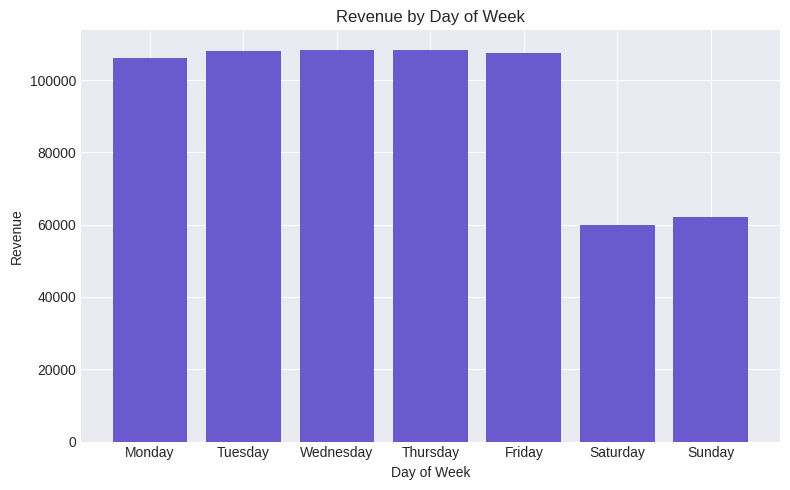

day_of_week,total_revenue_formatted
str,str
"""Monday""","""106,120"""
"""Tuesday""","""108,145"""
"""Wednesday""","""108,346"""
"""Thursday""","""108,292"""
"""Friday""","""107,587"""
"""Saturday""","""59,815"""
"""Sunday""","""62,078"""


In [7]:
# Q1.4: Revenue by day of week
# Your code here
revenue_by_day_of_week = (
    orders
    .with_columns(pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).alias("ordered_at_dt"))
    .with_columns(pl.col("ordered_at_dt").dt.strftime("%A").alias("day_of_week"))
    .group_by("day_of_week")
    .agg((pl.col("order_total") / 100).sum().alias("total_revenue"))
)

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
revenue_by_day_of_week = revenue_by_day_of_week.join(
    pl.DataFrame({"day_of_week": weekday_order, "sort_order": list(range(7))}),
    on="day_of_week", how="inner"
).sort("sort_order")

plt.figure(figsize=(8,5))
plt.bar(
    revenue_by_day_of_week["day_of_week"].to_list(),
    revenue_by_day_of_week["total_revenue"].to_list(),
    color="slateblue"
)
plt.title("Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

revenue_by_day_of_week_fmt = revenue_by_day_of_week.with_columns(
    pl.col("total_revenue").map_elements(lambda v: f"{v:,.0f}", return_dtype=pl.Utf8).alias("total_revenue_formatted")
).select(["day_of_week","total_revenue_formatted"])

revenue_by_day_of_week_fmt

## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.

,type,total_revenue,pct_share
0,beverage,"419,416.08",63.51%
1,jaffle,"240,965.85",36.49%


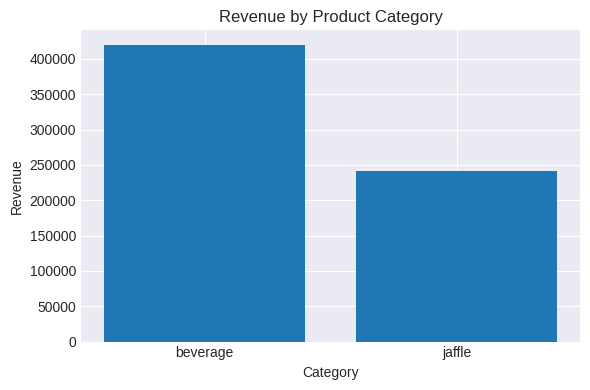

In [8]:
items_q = items if "quantity" in items.columns else items.with_columns(pl.lit(1).alias("quantity"))

# Step 1: join items with products
items_products = items_q.join(products, on="sku", how="inner")

# Step 2: join with orders to pull order_total
items_orders_products = items_products.join(
    orders.select(["id", "order_total"]),
    left_on="order_id",
    right_on="id",
    how="inner"
)

# Step 3: distribute each order's total revenue proportionally across its items
items_orders_products = items_orders_products.with_columns(
    pl.col("quantity").cast(pl.Float64).alias("qty"),
    pl.col("price").cast(pl.Float64).alias("price")
)

items_orders_products = items_orders_products.with_columns(
    (pl.col("qty") * pl.col("price")).alias("item_value")
)

# compute each item's share of its order total
items_orders_products = items_orders_products.with_columns(
    (pl.col("item_value") / pl.col("item_value").sum().over("order_id") * pl.col("order_total") / 100).alias("revenue")
)

# Step 4: aggregate by category
revenue_by_category = (
    items_orders_products
    .group_by("type")
    .agg(pl.col("revenue").sum().alias("total_revenue"))
    .sort("total_revenue", descending=True)
)

grand_total = float(revenue_by_category["total_revenue"].sum())
revenue_by_category = revenue_by_category.with_columns(
    (pl.col("total_revenue") / grand_total).alias("pct_share")
)

display(revenue_by_category.to_pandas().style.format({
    "total_revenue": "{:,.2f}",
    "pct_share": "{:.2%}"
}).set_caption("Revenue by Product Category (Aligned with Total Revenue)"))

x = revenue_by_category["type"].to_list()
y = revenue_by_category["total_revenue"].to_list()

plt.figure(figsize=(6,4))
plt.bar(x, y)
plt.title("Revenue by Product Category")
plt.ylabel("Revenue")
plt.xlabel("Category")
plt.tight_layout()
plt.show()


In [9]:
# Q2.2 Average price of products by type
# Your code here
avg_price_by_type = (
    products
    .with_columns((pl.col("price").cast(pl.Float64) / 100).alias("price"))
    .group_by("type")
    .agg(pl.col("price").mean().alias("avg_price"))
    .sort("avg_price", descending=True)
)

print(avg_price_by_type)

shape: (2, 2)
┌──────────┬───────────┐
│ type     ┆ avg_price │
│ ---      ┆ ---       │
│ str      ┆ f64       │
╞══════════╪═══════════╡
│ jaffle   ┆ 12.0      │
│ beverage ┆ 5.6       │
└──────────┴───────────┘


## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.

In [10]:
# Q3.1 Which stores have the highest revenue per day since opening?

orders_dt = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, strict=False).alias("ordered_at_dt")
)

rev_last = (
    orders_dt
    .group_by("store_id")
    .agg([
        (pl.col("order_total")/100).sum().alias("total_revenue"),
        pl.col("ordered_at_dt").max().alias("last_order_dt"),
    ])
)

revenue_per_day_by_store = (
    rev_last
    .join(
        stores.select([
            pl.col("id").alias("store_id"),
            pl.col("name").alias("store_name"),
            pl.col("opened_at").str.strptime(pl.Datetime, strict=False).alias("opened_at_dt"),
        ]),
        on="store_id"
    )
    .with_columns(
        ((pl.col("last_order_dt") - pl.col("opened_at_dt")).dt.total_days() + 1).alias("days_since_open")
    )
    .with_columns(
        (pl.col("total_revenue") / pl.col("days_since_open")).alias("revenue_per_day")
    )
    .select(["store_name", "total_revenue", "days_since_open", "revenue_per_day"])
    .sort("revenue_per_day", descending=True)
)

print(revenue_per_day_by_store)


shape: (2, 4)
┌──────────────┬───────────────┬─────────────────┬─────────────────┐
│ store_name   ┆ total_revenue ┆ days_since_open ┆ revenue_per_day │
│ ---          ┆ ---           ┆ ---             ┆ ---             │
│ str          ┆ f64           ┆ i64             ┆ f64             │
╞══════════════╪═══════════════╪═════════════════╪═════════════════╡
│ Brooklyn     ┆ 228226.28     ┆ 173             ┆ 1319.227052     │
│ Philadelphia ┆ 432155.65     ┆ 365             ┆ 1183.988082     │
└──────────────┴───────────────┴─────────────────┴─────────────────┘


shape: (2, 6)
┌──────────────┬──────────┬─────────────────┬─────────────────┬───────────────┬──────────────┐
│ store_name   ┆ tax_rate ┆ revenue_per_day ┆ avg_order_value ┆ total_revenue ┆ orders_count │
│ ---          ┆ ---      ┆ ---             ┆ ---             ┆ ---           ┆ ---          │
│ str          ┆ f64      ┆ f64             ┆ f64             ┆ f64           ┆ u32          │
╞══════════════╪══════════╪═════════════════╪═════════════════╪═══════════════╪══════════════╡
│ Philadelphia ┆ 0.06     ┆ 1183.988082     ┆ 10.590233       ┆ 432155.65     ┆ 40807        │
│ Brooklyn     ┆ 0.04     ┆ 1319.227052     ┆ 10.21558        ┆ 228226.28     ┆ 22341        │
└──────────────┴──────────┴─────────────────┴─────────────────┴───────────────┴──────────────┘


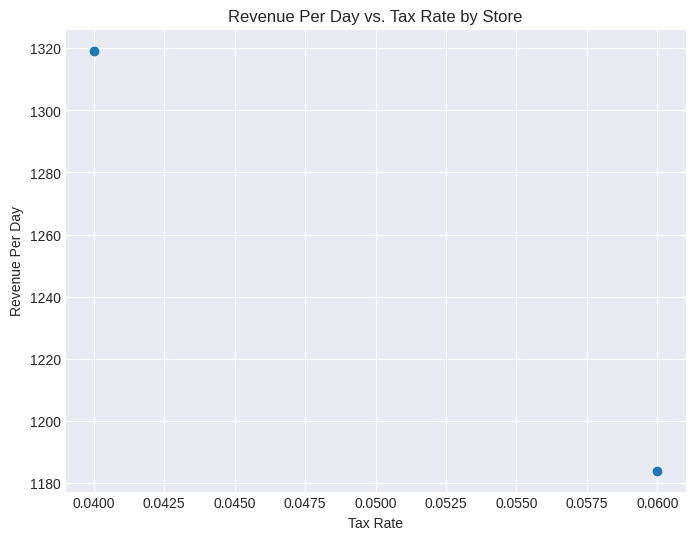

In [11]:
# Q3.2: Relationship between local tax rates and store performance

# Prepare store data with tax rate and opened_at_dt
stores_dt = stores.select([
    pl.col("id").alias("store_id"),
    pl.col("name").alias("store_name"),
    pl.col("opened_at").str.strptime(pl.Datetime, strict=False).alias("opened_at_dt"),
    pl.col("tax_rate")
])

# Calculate core performance metrics per store
perf_core = (
    orders_dt
    .group_by("store_id")
    .agg([
        (pl.col("order_total") / 100).sum().alias("total_revenue"),
        pl.len().alias("orders_count"),
        pl.col("ordered_at_dt").min().alias("first_order_dt"),
        pl.col("ordered_at_dt").max().alias("last_order_dt"),
    ])
)

# Join with store data and calculate days open and revenue per day
store_performance = (
    perf_core
    .join(stores_dt, on="store_id", how="left")
    .with_columns(
        ((pl.col("last_order_dt") - pl.col("opened_at_dt")).dt.total_days() + 1).alias("days_since_open")
    )
    .with_columns(
        (pl.col("total_revenue") / pl.col("days_since_open")).alias("revenue_per_day")
    )
    .with_columns(
        (pl.col("total_revenue") / pl.col("orders_count")).alias("avg_order_value")
    )
)

# Select relevant columns for the tax rate performance analysis
tax_rate_performance = store_performance.select([
    "store_name",
    "tax_rate",
    "revenue_per_day",
    "avg_order_value",
    "total_revenue",
    "orders_count"
])

print(tax_rate_performance)

# Visualize the relationship between tax rate and revenue per day
plt.figure(figsize=(8, 6))
plt.scatter(tax_rate_performance["tax_rate"], tax_rate_performance["revenue_per_day"])
plt.title("Revenue Per Day vs. Tax Rate by Store")
plt.xlabel("Tax Rate")
plt.ylabel("Revenue Per Day")
plt.show()



## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

shape: (63_148, 1)
┌───────────────────┐
│ total_order_value │
│ ---               │
│ i64               │
╞═══════════════════╡
│ 1802              │
│ 636               │
│ 742               │
│ 530               │
│ 636               │
│ …                 │
│ 416               │
│ 728               │
│ 1352              │
│ 728               │
│ 416               │
└───────────────────┘
shape: (9, 2)
┌────────────┬───────────────────┐
│ statistic  ┆ total_order_value │
│ ---        ┆ ---               │
│ str        ┆ str               │
╞════════════╪═══════════════════╡
│ count      ┆ 63,148            │
│ null_count ┆ 0                 │
│ mean       ┆ 1,046             │
│ std        ┆ 1,026             │
│ min        ┆ 0                 │
│ 25%        ┆ 530               │
│ 50%        ┆ 636               │
│ 75%        ┆ 1,165             │
│ max        ┆ 10,281            │
└────────────┴───────────────────┘


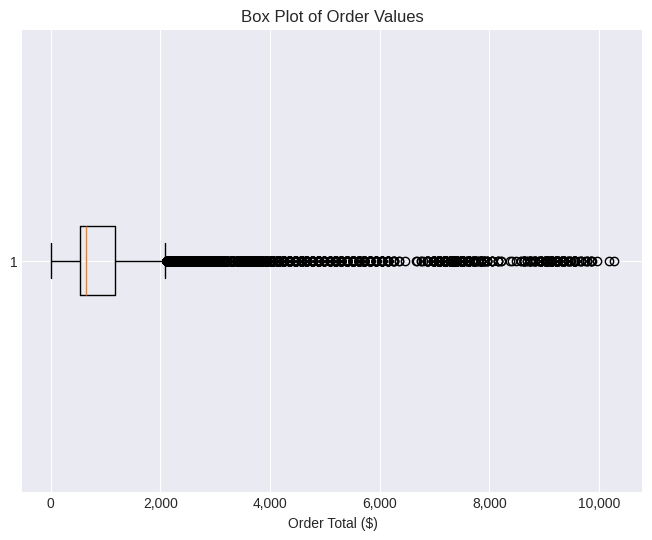

In [12]:
# Q4.1: Distribution of order values
# Your code here
order_value_distribution = orders.select([
    pl.col("order_total").alias("total_order_value")
])

print(order_value_distribution)

# Describe stats and format with commas
desc = order_value_distribution.describe()
for col in desc.columns:
    if desc[col].dtype in (pl.Int64, pl.Float64):
        desc = desc.with_columns(pl.col(col).map_elements(lambda x: f"{x:,.0f}" if x is not None else None, return_dtype=pl.Utf8))
print(desc)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(order_value_distribution["total_order_value"], vert=False)
plt.title("Box Plot of Order Values")
plt.xlabel("Order Total ($)")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.show()

In [13]:
# Q4.2: Repeat customers analysis
# Your code here

customer_order_counts = (
    orders
    .group_by("customer")
    .agg(pl.len().alias("num_orders"))
)

repeat_customers = customer_order_counts.filter(pl.col("num_orders") > 1)
repeat_customer_analysis = repeat_customers.height
print("Number of repeat customers:", repeat_customer_analysis)

Number of repeat customers: 920


shape: (10, 3)
┌─────────────────────────────────┬───────────────┬──────────────────────┐
│ customer                        ┆ total_revenue ┆ name                 │
│ ---                             ┆ ---           ┆ ---                  │
│ str                             ┆ str           ┆ str                  │
╞═════════════════════════════════╪═══════════════╪══════════════════════╡
│ ea3ada4c-8ffa-4e73-a51f-27711f… ┆ 262,647       ┆ David Leonard        │
│ 4fb3b92c-29cc-410f-a898-9784c4… ┆ 259,037       ┆ Jesse Moore          │
│ 99facd33-7b11-4955-aa0d-ccd118… ┆ 258,515       ┆ Diane Davis          │
│ 8bbf796d-0862-41c6-b533-38d6c2… ┆ 252,703       ┆ Holly Johnson        │
│ bc94ad77-6703-48d9-85d9-7908e7… ┆ 249,821       ┆ Gregory Hayes        │
│ 3ddc958e-73f5-4fe9-804e-d63c8b… ┆ 247,510       ┆ Julie Robinson       │
│ 0b92fd92-9200-47fe-9b57-9ada88… ┆ 246,325       ┆ Christopher Robinson │
│ a54f0762-0ac2-4821-bb45-835fd4… ┆ 244,102       ┆ Douglas Burgess      │
│ 666caf4d

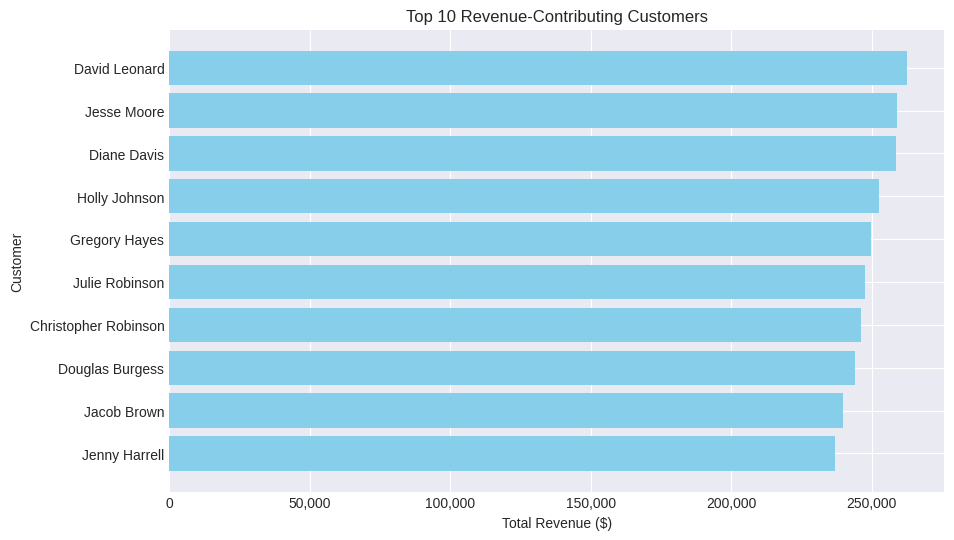

In [14]:
# Q4.3: Top revenue contributors
# Your code here
# Aggregate total revenue per customer
top_revenue_customers = orders.group_by("customer").agg([
    pl.sum("order_total").alias("total_revenue")
])
# Sort customers by total revenue in descending order
top_revenue_customers = top_revenue_customers.sort("total_revenue", descending=True)

# Join with customers dataframe to get customer names
top_revenue_customers = top_revenue_customers.join(
    customers.select(["id", "name"]),
    left_on="customer",
    right_on="id",
    how="left"
  )
top10_formatted = top_revenue_customers.head(10).with_columns(
    pl.col("total_revenue").map_elements(lambda x: f"{x:,}", return_dtype=pl.Utf8)
)
print(top10_formatted)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Extract names and revenues for plotting
names = top_revenue_customers["name"].head(10).to_list()
revenues = top_revenue_customers["total_revenue"].head(10).to_list()

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(names, revenues, color="skyblue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Customer")
plt.title("Top 10 Revenue-Contributing Customers")
plt.gca().invert_yaxis()  # so the top contributor is at the top

# Format x-axis numbers with commas
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()

## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [15]:
# Q5.1: Calculate gross margin per product
# Your code here

# Calculate total supply cost per product
supply_costs_per_product = (
    supplies
    .group_by("sku")
    .agg(pl.col("cost").sum().alias("total_supply_cost"))
)

# Join products and supply costs, then calculate gross margin
product_margins = (
    products
    .join(supply_costs_per_product, on="sku", how="left")
    .with_columns([
        pl.col("price").cast(pl.Float64),
        pl.col("total_supply_cost").fill_null(0).cast(pl.Float64),
        (pl.col("price") - pl.col("total_supply_cost")).alias("gross_margin")
    ])
    .select(["sku", "name", "type", "price", "total_supply_cost", "gross_margin"])
)

print(product_margins)

shape: (10, 6)
┌─────────┬─────────────────────────┬──────────┬────────┬───────────────────┬──────────────┐
│ sku     ┆ name                    ┆ type     ┆ price  ┆ total_supply_cost ┆ gross_margin │
│ ---     ┆ ---                     ┆ ---      ┆ ---    ┆ ---               ┆ ---          │
│ str     ┆ str                     ┆ str      ┆ f64    ┆ f64               ┆ i64          │
╞═════════╪═════════════════════════╪══════════╪════════╪═══════════════════╪══════════════╡
│ JAF-001 ┆ nutellaphone who dis?   ┆ jaffle   ┆ 1100.0 ┆ 121.0             ┆ 979          │
│ JAF-002 ┆ doctor stew             ┆ jaffle   ┆ 1100.0 ┆ 251.0             ┆ 849          │
│ JAF-003 ┆ the krautback           ┆ jaffle   ┆ 1200.0 ┆ 366.0             ┆ 834          │
│ JAF-004 ┆ flame impala            ┆ jaffle   ┆ 1400.0 ┆ 343.0             ┆ 1057         │
│ JAF-005 ┆ mel-bun                 ┆ jaffle   ┆ 1200.0 ┆ 239.0             ┆ 961          │
│ BEV-001 ┆ tangaroo                ┆ beverage ┆ 600.0 

shape: (10, 6)
┌─────────┬─────────────────────────┬──────────┬────────┬───────────────────┬──────────────┐
│ sku     ┆ name                    ┆ type     ┆ price  ┆ total_supply_cost ┆ gross_margin │
│ ---     ┆ ---                     ┆ ---      ┆ ---    ┆ ---               ┆ ---          │
│ str     ┆ str                     ┆ str      ┆ f64    ┆ f64               ┆ i64          │
╞═════════╪═════════════════════════╪══════════╪════════╪═══════════════════╪══════════════╡
│ JAF-004 ┆ flame impala            ┆ jaffle   ┆ 1400.0 ┆ 343.0             ┆ 1057         │
│ JAF-001 ┆ nutellaphone who dis?   ┆ jaffle   ┆ 1100.0 ┆ 121.0             ┆ 979          │
│ JAF-005 ┆ mel-bun                 ┆ jaffle   ┆ 1200.0 ┆ 239.0             ┆ 961          │
│ JAF-002 ┆ doctor stew             ┆ jaffle   ┆ 1100.0 ┆ 251.0             ┆ 849          │
│ JAF-003 ┆ the krautback           ┆ jaffle   ┆ 1200.0 ┆ 366.0             ┆ 834          │
│ BEV-004 ┆ for richer or pourover  ┆ beverage ┆ 700.0 

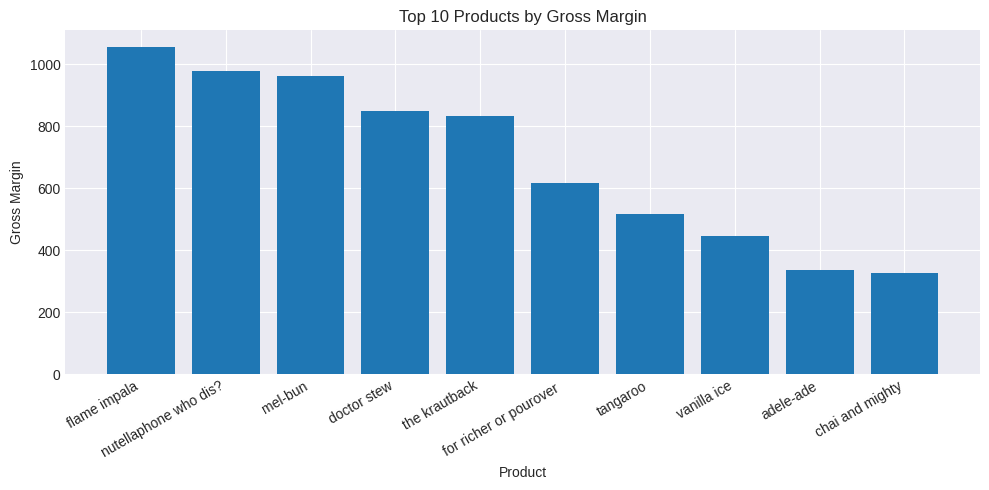

In [16]:
# Q5.2: Products with highest profit margins
# Your code here

highest_margin_products = (
    product_margins
    .sort("gross_margin", descending=True)
)

print(highest_margin_products)

top10 = highest_margin_products.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["name"], top10["gross_margin"])
plt.title("Top 10 Products by Gross Margin")
plt.xlabel("Product")
plt.ylabel("Gross Margin")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

shape: (10, 3)
┌─────────────────────────────────┬────────────┬──────────────┐
│ order_id                        ┆ order_size ┆ order_profit │
│ ---                             ┆ ---        ┆ ---          │
│ str                             ┆ u32        ┆ i64          │
╞═════════════════════════════════╪════════════╪══════════════╡
│ 7a347b5c-4e65-4905-92d0-292575… ┆ 1          ┆ 446          │
│ 17edc5ec-9f8d-4794-a3ed-32af59… ┆ 1          ┆ 446          │
│ 10f064ce-ad48-4524-bf39-da204c… ┆ 1          ┆ 337          │
│ ebe15fd6-601a-4a43-88d1-e09e71… ┆ 1          ┆ 337          │
│ ae65ef6c-b568-40c6-ba8b-97ac73… ┆ 1          ┆ 618          │
│ 235ee41b-a6d9-47ff-a354-d3071c… ┆ 1          ┆ 337          │
│ 831ab62b-d119-42ec-bc19-9fe66d… ┆ 1          ┆ 325          │
│ 35772b4f-9fcf-4b33-93f0-fe00d1… ┆ 1          ┆ 337          │
│ 1009f52e-0371-4e11-a814-c45c8e… ┆ 1          ┆ 518          │
│ 95feffef-b18c-4475-8fe5-21a6e0… ┆ 1          ┆ 446          │
└────────────────────────

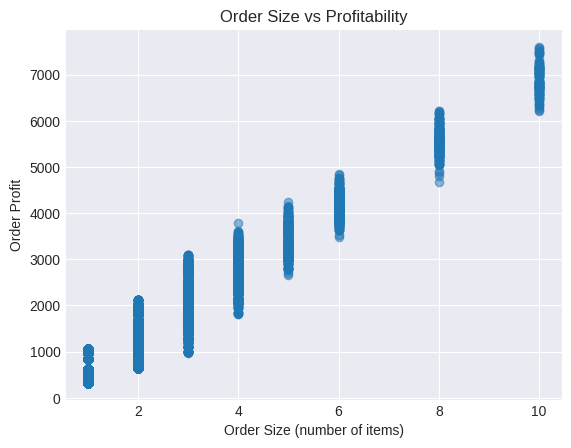

In [17]:
# Q5.3: Order size vs profitability
# Your code here

order_size_profitability = (
    items
    .join(
        product_margins.select(["sku", "gross_margin"]),
        on="sku",
        how="left"
    )
    .with_columns(
        pl.col("gross_margin").fill_null(0).alias("item_profit")
    )
    .group_by("order_id")
    .agg([
        pl.len().alias("order_size"),
        pl.col("item_profit").sum().alias("order_profit")
    ])
    .sort("order_size")
)

print(order_size_profitability.head(10))

plt.scatter(order_size_profitability["order_size"], order_size_profitability["order_profit"], alpha=0.5)
plt.title("Order Size vs Profitability")
plt.xlabel("Order Size (number of items)")
plt.ylabel("Order Profit")
plt.show()

In [18]:
store_profit_numeric = (
    items
    .join(product_margins.select(["sku", "gross_margin"]), on="sku", how="left")
    .with_columns(pl.col("gross_margin").fill_null(0).alias("item_profit"))
    .join(orders.select(["id", "store_id"]), left_on="order_id", right_on="id", how="left")
    .join(stores.select(["id", "name"]).rename({"id": "store_id"}), on="store_id", how="left")
    .group_by(["store_id", "name"])
    .agg(pl.col("item_profit").sum().alias("total_profit"))
)

store_revenue = (
    orders
    .group_by("store_id")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
)

store_profitability = (
    store_profit_numeric
    .join(store_revenue, on="store_id", how="left")
    .with_columns(pl.col("total_revenue").fill_null(0))
    .with_columns(
        pl.when(pl.col("total_revenue") > 0)
          .then(pl.col("total_profit") / pl.col("total_revenue"))
          .otherwise(None)
          .alias("profit_margin")
    )
    .with_columns([
        pl.col("total_profit").map_elements(lambda x: f"{int(x):,}", return_dtype=pl.Utf8).alias("total_profit"),
        pl.col("total_revenue").map_elements(lambda x: f"{int(x):,}", return_dtype=pl.Utf8).alias("total_revenue"),
        (pl.col("profit_margin") * 100).map_elements(lambda x: f"{x:.2f}%" if x is not None else None, return_dtype=pl.Utf8).alias("profit_margin_pct"),
    ])
    .select(["store_id", "name", "total_profit", "total_revenue", "profit_margin_pct"])
    .sort("total_profit", descending=True)
)

print(store_profitability)

shape: (2, 5)
┌────────────────────────────────┬──────────────┬──────────────┬───────────────┬───────────────────┐
│ store_id                       ┆ name         ┆ total_profit ┆ total_revenue ┆ profit_margin_pct │
│ ---                            ┆ ---          ┆ ---          ┆ ---           ┆ ---               │
│ str                            ┆ str          ┆ str          ┆ str           ┆ str               │
╞════════════════════════════════╪══════════════╪══════════════╪═══════════════╪═══════════════════╡
│ a9128331-08d7-41a2-b615-21283e ┆ Philadelphia ┆ 32,358,060   ┆ 43,215,565    ┆ 74.88%            │
│ …                              ┆              ┆              ┆               ┆                   │
│ a2a24e87-dec8-4f5d-9c9e-0e9849 ┆ Brooklyn     ┆ 17,408,441   ┆ 22,822,628    ┆ 76.28%            │
│ …                              ┆              ┆              ┆               ┆                   │
└────────────────────────────────┴──────────────┴──────────────┴─────────────

## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

### Recommendation 1:
Improve Weekend Sales with Promotions and Events. Targeted weekend bundles, local events, and flash discounts could close the gap between midweek averages and weekends.

Recommendation 1: Improve Weekend Sales with Promotions and Events.

Targeted weekend bundles, local events, and flash discounts could close the gap between midweek averages and weekends.


shape: (2, 2)
┌───────────────────┬───────────────────┐
│ Day Type          ┆ Avg Daily Revenue │
│ ---               ┆ ---               │
│ str               ┆ str               │
╞═══════════════════╪═══════════════════╡
│ Midweek (Mon–Fri) ┆ $107,698          │
│ Weekend (Sat–Sun) ┆ $60,946           │
└───────────────────┴───────────────────┘


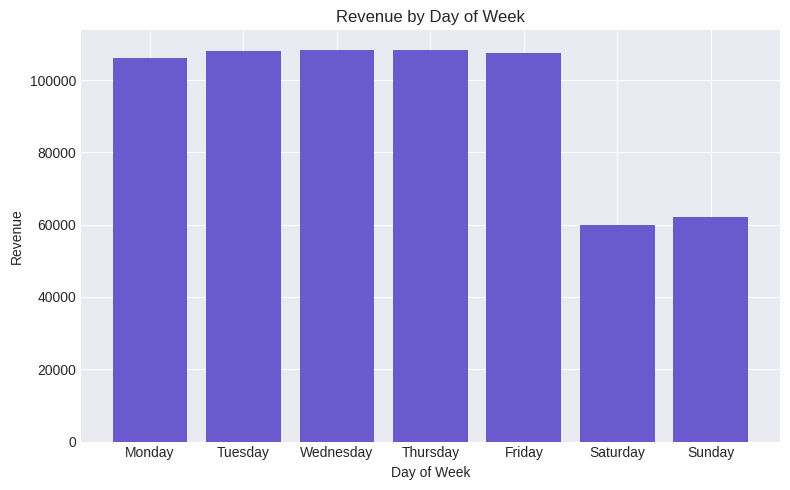

Sales drop by 43.41% from weekdays to weekends.


In [19]:
# Supporting analysis for Recommendation 1

print(
    "Recommendation 1: Improve Weekend Sales with Promotions and Events.\n\n"
    "Targeted weekend bundles, local events, and flash discounts could close the gap between midweek averages and weekends.\n\n"
)

#Supporting analysis: Table showcasing averages during weekdays and weekends + bar graph

if "day_of_week" not in orders_dt.columns:
    orders_dt = orders_dt.with_columns(
        orders_dt["ordered_at_dt"].dt.strftime("%A").alias("day_of_week")
    )

# total revenue per day of the week
revenue_by_day = (
    orders_dt
    .group_by("day_of_week")
    .agg((pl.col("order_total") / 100).sum().alias("total_revenue"))
)

# Sorted by weekday order

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
revenue_by_day = revenue_by_day.with_columns(
    pl.Series("sort_order", [weekday_order.index(day) for day in revenue_by_day["day_of_week"]])
).sort("sort_order").drop("sort_order")

# Midweek and weekend averages
midweek_avg = (
    revenue_by_day
    .filter(pl.col("day_of_week").is_in(weekday_order[:5]))
    ["total_revenue"].mean()
)
weekend_avg = (
    revenue_by_day
    .filter(pl.col("day_of_week").is_in(weekday_order[5:]))
    ["total_revenue"].mean()
)

# Summary table for key metric results
summary_df = pl.DataFrame({
    "Day Type": ["Midweek (Mon–Fri)", "Weekend (Sat–Sun)"],
    "Avg Daily Revenue": [f"${midweek_avg:,.0f}", f"${weekend_avg:,.0f}"]
})

# Display summary table
print(summary_df)


# Revenue by day of week visualization
plt.figure(figsize=(8,5))
plt.bar(
    revenue_by_day_of_week["day_of_week"].to_list(),
    revenue_by_day_of_week["total_revenue"].to_list(),
    color="slateblue"
)
plt.title("Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

#percentage drop

old_value = 107698
new_value = 60946

percentage_drop = ((old_value - new_value) / old_value) * 100
print(f"Sales drop by {percentage_drop:.2f}% from weekdays to weekends.")

### Recommendation 2:
Prioritize expansion in Brooklyn due to low tax rate and strong revenue per day, it is an optimal location to scale operations or launch new concepts.

Recommendation 2: Prioritize Expansion in Brooklyn due to Low Tax Rate and Strong Revenue per Day.

Brooklyn achieves higher revenue per day than Philadelphia despite having fewer total sales days.
Its lower tax rate (4% vs. 6% in Philadelphia) enhances net profitability, making it the optimal location to scale operations or launch new concepts.


shape: (2, 5)
┌──────────────┬──────────────┬─────────────────┬─────────────────────┬─────────────────────┐
│ store_name   ┆ Tax Rate (%) ┆ Revenue/Day ($) ┆ Avg Order Value ($) ┆ Net Revenue/Day ($) │
│ ---          ┆ ---          ┆ ---             ┆ ---                 ┆ ---                 │
│ str          ┆ str          ┆ i64             ┆ f64                 ┆ i64                 │
╞══════════════╪══════════════╪═════════════════╪═════════════════════╪═════════════════════╡
│ Brooklyn     ┆ 4.0          ┆ 1319            ┆ 10.22               ┆ 1266                │
│ Philadelphia ┆ 6.0          ┆ 1184            ┆ 10.59               ┆ 

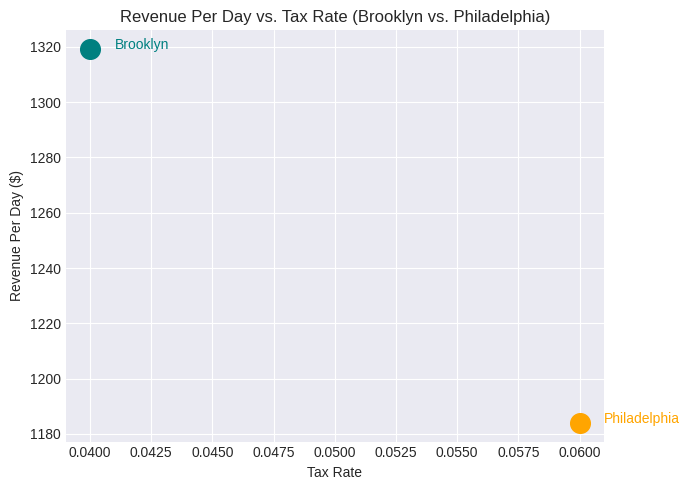

In [20]:
# Supporting analysis for Recommendation 2

print(
    "Recommendation 2: Prioritize Expansion in Brooklyn due to Low Tax Rate and Strong Revenue per Day.\n\n"
    "Brooklyn achieves higher revenue per day than Philadelphia despite having fewer total sales days.\n"
    "Its lower tax rate (4% vs. 6% in Philadelphia) enhances net profitability, making it the optimal "
    "location to scale operations or launch new concepts.\n\n"
)

# Filter for Brooklyn and Philadelphia
brooklyn_perf = tax_rate_performance.filter(pl.col("store_name") == "Brooklyn")
philly_perf = tax_rate_performance.filter(pl.col("store_name") == "Philadelphia")

# Calculate net revenue/day (after tax)
brooklyn_net = brooklyn_perf.with_columns(
    (pl.col("revenue_per_day") * (1 - pl.col("tax_rate"))).alias("net_revenue_per_day")
)
philly_net = philly_perf.with_columns(
    (pl.col("revenue_per_day") * (1 - pl.col("tax_rate"))).alias("net_revenue_per_day")
)

# Combine into a single summary table
summary_df = pl.concat([
    brooklyn_net.select([
        "store_name",
        "tax_rate",
        "revenue_per_day",
        "avg_order_value",
        "net_revenue_per_day"
    ]),
    philly_net.select([
        "store_name",
        "tax_rate",
        "revenue_per_day",
        "avg_order_value",
        "net_revenue_per_day"
    ])
])

# Format values for readability
summary_fmt = summary_df.with_columns([
    (pl.col("tax_rate") * 100).round(1).cast(pl.Utf8).alias("Tax Rate (%)"),
    pl.col("revenue_per_day").round(0).cast(pl.Int64).alias("Revenue/Day ($)"),
    pl.col("avg_order_value").round(2).alias("Avg Order Value ($)"),
    pl.col("net_revenue_per_day").round(0).cast(pl.Int64).alias("Net Revenue/Day ($)")
]).select([
    "store_name", "Tax Rate (%)", "Revenue/Day ($)", "Avg Order Value ($)", "Net Revenue/Day ($)"
])

print(summary_fmt)

# Calculate percentage advantage (Brooklyn vs. Philadelphia)
brooklyn_value = float(brooklyn_net["net_revenue_per_day"][0])
philly_value = float(philly_net["net_revenue_per_day"][0])

percentage_advantage = ((brooklyn_value - philly_value) / philly_value) * 100
print(f"\nBrooklyn generates {percentage_advantage:.1f}% more after-tax revenue per day than Philadelphia.")

#graph from q3.2 but color coded and only showing the places with revenue:

# Visualization: Only Brooklyn and Philadelphia
plt.figure(figsize=(7,5))

# Brooklyn point
plt.scatter(
    brooklyn_perf["tax_rate"],
    brooklyn_perf["revenue_per_day"],
    s=200, c="teal"
)

# Philadelphia point
plt.scatter(
    philly_perf["tax_rate"],
    philly_perf["revenue_per_day"],
    s=200, c="orange"
)

# Labels
plt.text(
    brooklyn_perf["tax_rate"][0] + 0.001,
    brooklyn_perf["revenue_per_day"][0],
    "Brooklyn",
    fontsize=10,
    color="teal"
)
plt.text(
    philly_perf["tax_rate"][0] + 0.001,
    philly_perf["revenue_per_day"][0],
    "Philadelphia",
    fontsize=10,
    color="orange"
)

# Axis titles
plt.title("Revenue Per Day vs. Tax Rate (Brooklyn vs. Philadelphia)")
plt.xlabel("Tax Rate")
plt.ylabel("Revenue Per Day ($)")
plt.tight_layout()
plt.show()


### Recommendation 3:
[Write your third recommendation here]

Recommendation 3: Focus on High-Margin Products to Maximize Profitability.

Analysis shows that premium jaffles and select beverages generate the highest gross margins,with products like the
'Flame Impala' jaffle and 'Pourover Coffee' achieving margins above $6–$10 per unit.
By prioritizing marketing, inventory, and pricing strategies around these top-margin items,
 the business can significantly improve overall profitability.


shape: (10, 10)
┌─────────┬──────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ sku     ┆ type     ┆ name       ┆ line_items ┆ … ┆ supply_co ┆ unit_marg ┆ total_mar ┆ total_rev │
│ ---     ┆ ---      ┆ ---        ┆ ---        ┆   ┆ st_usd    ┆ in_usd    ┆ gin_usd   ┆ enue_usd  │
│ str     ┆ str      ┆ str        ┆ u32        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆          ┆            ┆            ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪══════════╪════════════╪═══════════

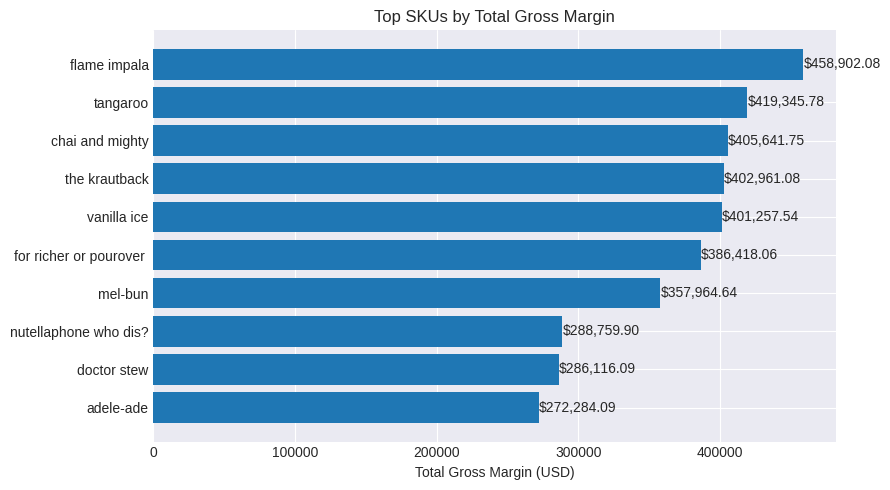

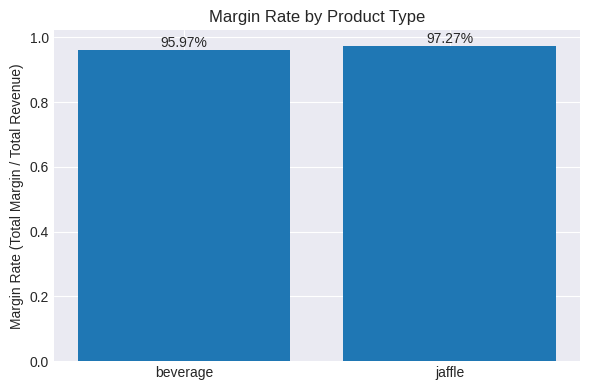

In [21]:
# Supporting analysis for Recommendation 3
print(
    "Recommendation 3: Focus on High-Margin Products to Maximize Profitability.\n\n"
    "Analysis shows that premium jaffles and select beverages generate the highest gross margins,with products like the\n"
   "'Flame Impala' jaffle and 'Pourover Coffee' achieving margins above $6–$10 per unit.\n"
    "By prioritizing marketing, inventory, and pricing strategies around these top-margin items,\n "
    "the business can significantly improve overall profitability.\n\n"
)
import polars as pl
import matplotlib.pyplot as plt


if "quantity" in items.columns:
   items_q = items.with_columns(pl.col("quantity").cast(pl.Int64).alias("qty"))
else:
   items_q = items.with_columns(pl.lit(1).cast(pl.Int64).alias("qty"))


prod_cols = products.columns
name_col = "name" if "name" in prod_cols else ("product_name" if "product_name" in prod_cols else None)


joined = (
   items_q
   .join(products, on="sku", how="inner")
   .join(supplies.select(["sku", "cost"]), on="sku", how="left")
   .with_columns([
       pl.col("price").cast(pl.Float64).alias("price_cents"),
       pl.col("cost").cast(pl.Float64).alias("cost_cents")
   ])
   .with_columns([
       (pl.col("price_cents") / 100).alias("price_usd"),
       (pl.col("cost_cents").fill_null(0) / 100).alias("supply_cost_usd")
   ])
   .with_columns((pl.col("price_usd") - pl.col("supply_cost_usd")).alias("unit_margin_usd"))
)


group_cols = ["sku", "type"] + ([name_col] if name_col else [])


sku_margin = (
   joined
   .group_by(group_cols)
   .agg([
       pl.len().alias("line_items"),
       pl.col("qty").sum().alias("units_sold"),
       pl.col("price_usd").first().alias("price_usd"),
       pl.col("supply_cost_usd").first().alias("supply_cost_usd"),
       pl.col("unit_margin_usd").first().alias("unit_margin_usd"),
       (pl.col("qty") * pl.col("unit_margin_usd")).sum().alias("total_margin_usd"),
       (pl.col("qty") * pl.col("price_usd")).sum().alias("total_revenue_usd"),
   ])
   .sort("total_margin_usd", descending=True)
)


top_n = 10
top_margin_skus = sku_margin.head(top_n)
print(top_margin_skus)


type_margin = (
   sku_margin
   .group_by("type")
   .agg([
       pl.col("total_margin_usd").sum().alias("total_margin_usd"),
       pl.col("total_revenue_usd").sum().alias("total_revenue_usd"),
       (pl.col("total_margin_usd").sum() / pl.col("total_revenue_usd").sum()).alias("margin_rate")
   ])
   .sort("total_margin_usd", descending=True)
)
print("\nMargin by Product Type:")
print(type_margin)


if name_col:
   labels = top_margin_skus[name_col].to_list()
   labels = [lbl if lbl is not None else sku for lbl, sku in zip(labels, top_margin_skus["sku"].to_list())]
else:
   labels = top_margin_skus["sku"].to_list()


values = top_margin_skus["total_margin_usd"].to_list()


plt.figure(figsize=(9, 5))
plt.barh(labels[::-1], values[::-1])
plt.title("Top SKUs by Total Gross Margin")
plt.xlabel("Total Gross Margin (USD)")
for i, v in enumerate(values[::-1]):
   plt.text(v, i, f"${v:,.2f}", va="center", ha="left")
plt.tight_layout()
plt.show()


types = type_margin["type"].to_list()
type_vals = type_margin["margin_rate"].to_list()


plt.figure(figsize=(6, 4))
plt.bar(types, type_vals)
plt.title("Margin Rate by Product Type")
plt.ylabel("Margin Rate (Total Margin / Total Revenue)")
for i, v in enumerate(type_vals):
   plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


## Executive Summary

[Write your executive summary here - up to 1 page when printed]

### Key Findings:
1. At the Jaffle Shop, revenue by day of the week shows a significant drop on weekends. The midweek averages around 108,000 dollars per day, but weekends drop to around 60,000 dollars, which is a 43.41% drop.

2. Brooklyn achieves higher revenue per day (1,319 dollars) than Philadelphia (1,184 dollars) despite having fewer total sales days (173 vs. 365) and has a lower tax rate (4% vs. 6%), making it a strong target for expansion.

3. Analysis shows that premium jaffles and select beverages generate the highest gross margins,with products like the 'Flame Impala' jaffle and 'Pourover Coffee' achieving margins above $6–$10 per unit.

### Strategic Recommendations:
1. Improve Weekend Sales with Promotions and Events.Targeted weekend bundles, local events, and flash discounts could close this gap. Raising weekend revenue to just 80% of midweek levels could add ~$1M annually.


2. Prioritize Expansion in Brooklyn due to Low Tax Rate and Strong Revenue per Day. Start with a pilot store in a nearby high-potential area, and use local marketing and partnerships to attract customers. Leverage existing supply chains and staffing to control costs. Track revenue and retention, then expand further if results meet expectations.

3. Increase marketing and pricing strategies around top-margin items such as the "Flame Impala" jaffle and "Pourover Coffee". Promoting these products and offering bundled deals can increase average order value and boost overall profitability.


